In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras import models
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GRU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import collections
from pathlib import Path
import re
from nltk.corpus import stopwords
import nltk

In [3]:
def openTextasList(filename):
  with open(filename, encoding="utf8") as file_in:
    lines = []
    for line in file_in:
      # remove whitespace characters like `\n` at the end of each line
      line=line.strip()
      lines.append(line)
  return(lines)

positive=openTextasList("/content/8000religion.txt")
negative=openTextasList("/content/8000notcb.txt")
alldoc=positive+negative
print("there are %d positive twittes\n %s " % (len(positive),positive[0:5]))
print("there are %d negative twittes\n %s " % (len(negative),negative[0:5]))


there are 8000 positive twittes
 ["Sudeep, did she invite him though? No right? Why are you getting worded up? You're okay with Parvesh Verma cause he speaks against Muslims but against an idiot like Imam because he called for chakka jam?", '@discerningmumin Islam has never been a resistance to oppression. It has always been source of oppression to both believers and non believer', 'Boy, your comment about Journalists wanting to keep churches closed is beneath you. As a Christian woman and human being your bosses filth is brushing off on you. Not at all unbiased and a down right lie. SHAME ON YOU.', '@ShashiTharoor @INCIndia Hindus were and are getting killed by Muslims terriorists in Kashmir. Congress mukt bharat will certainly happen if congressmen like you don’t change their idealogies and keep sounding like idiots. You actually don’t need enemies.', 'White supremicists? How many do you know? There a few idiots in all races. Where is anti-semitism coming from? Dems, BLM, Antifa, Mus

In [4]:
# define training labels
class_label = np.array(["positive" for _ in range(8000)] + ["negative"for _ in range(8000)])
# list of strings
lst = alldoc

# list of int
lst2 = class_label

# Calling DataFrame constructor after zipping
df = pd.DataFrame(list(zip(lst, lst2)),
			columns =['text', 'labels'])

#Define some required  parameters and paths
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20 # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 53  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [5]:
#Define the helper functions:
def deep_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test):

    model.compile(optimizer='adam'

                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])

    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    results = model.evaluate(X_test, y_test)
    print("test results:"+str(results))
    return history


def eval_metric(history, metric_name):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):

    save_path='/content/model_cb_em'
    callbacks_save=ModelCheckpoint(save_path, monitor='accuracy', verbose=2, save_best_only=True, period=1)
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=1
              ,callbacks=[callbacks_save] )
    results = model.evaluate(X_test, y_test)

    return results


def remove_stopwords(input_text):

    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def remove_mentions(input_text):

    return re.sub(r'@\w+', '', input_text)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Define the simple neural network model for plotting
def create_simple_nn(nb_words, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=nb_words, output_dim=20, input_length=max_len))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Constants for the model
NB_WORDS = 10000  # number of words in the vocabulary
MAX_LEN = 53  # maximum length of input sequences

# Create the simple NN model
simple_nn_model = create_simple_nn(NB_WORDS, MAX_LEN)

# Summary of the model
simple_nn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 53, 20)            200000    
                                                                 
 flatten (Flatten)           (None, 1060)              0         
                                                                 
 dense (Dense)               (None, 1)                 1061      
                                                                 
Total params: 201061 (785.39 KB)
Trainable params: 201061 (785.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Preporeation the data set:
df = df.reindex(np.random.permutation(df.index))

#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(df.text, df["labels"], test_size=0.2, random_state=40)

#Convert words into integers
tk = Tokenizer(num_words=NB_WORDS,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

#Equal length of sequences
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

#Converting the target classes to numbers
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le,2)
y_test_oh = to_categorical(y_test_le,2)

#Splitting off validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_le,
                                                                      test_size=0.1, random_state=37)
assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

In [8]:
#Training word embeddings
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 20, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(1, activation='sigmoid'))
emb_model.summary()

emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb, X_test_seq_trunc, y_test_le)
emb_history.history['accuracy'][-1]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 53, 20)            200000    
                                                                 
 flatten_1 (Flatten)         (None, 1060)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1061      
                                                                 
Total params: 201061 (785.39 KB)
Trainable params: 201061 (785.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
23/23 [==============================] - 3s 40ms/step - loss: 0.6403 - accuracy: 0.6813 - val_loss: 0.5870 - val_accuracy: 0.7664
Epoch 2/20
23/23 [==============================] - 0s 22ms/step - loss: 0.4994 - accuracy: 0.8056 - val_loss: 0.4412 - val_accuracy: 0.8

0.9879340529441833

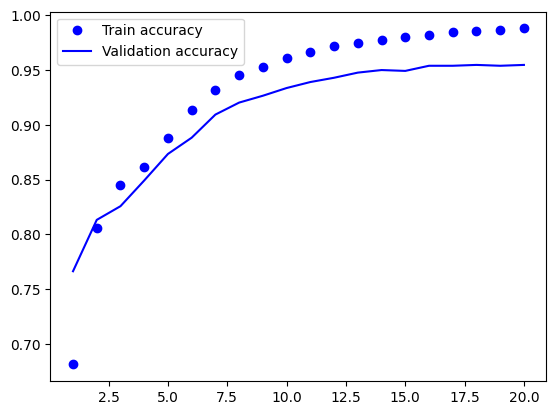

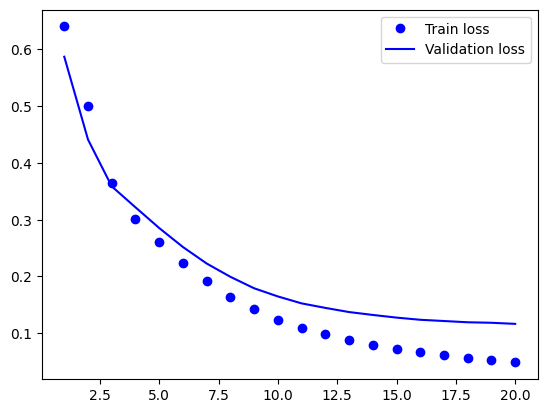

In [9]:
eval_metric(emb_history, 'accuracy')
eval_metric(emb_history, 'loss')

In [11]:
#Training word embeddings with CNN

emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 20, input_length=MAX_LEN))
emb_model.add(layers.Conv1D(128, 5, activation='relu'))
emb_model.add(layers.GlobalMaxPooling1D())
emb_model.add(layers.Dense(10, activation='relu'))
emb_model.add(layers.Dense(1, activation='sigmoid'))
emb_model.summary()

emb_history_CNN = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb, X_test_seq_trunc, y_test_le)
emb_history_CNN.history['accuracy'][-1]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 53, 20)            200000    
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 128)           12928     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 214229 (836.83 KB)
Trainable params: 214229 (836.83 KB)
Non-trainable params: 0 (0.00 Byte)
______________

0.999913215637207

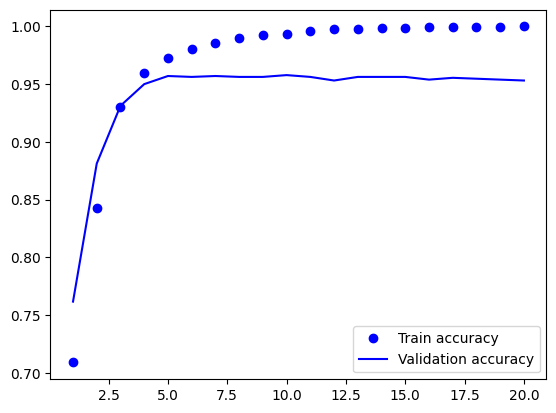

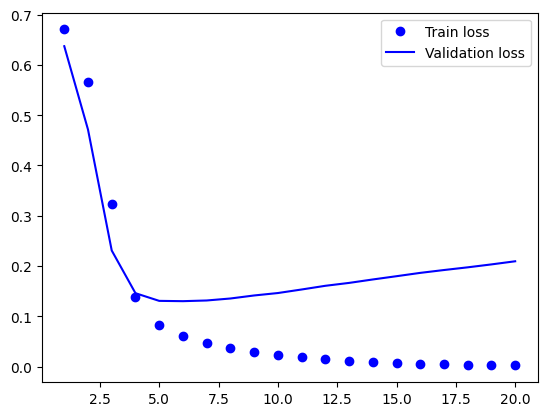

In [13]:
eval_metric(emb_history_CNN, 'accuracy')
eval_metric(emb_history_CNN, 'loss')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 53, 20)            200000    
                                                                 
 lstm (LSTM)                 (None, 128)               76288     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 276417 (1.05 MB)
Trainable params: 276417 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
23/23 [==============================] - 13s 476ms/step - loss: 0.5933 - accuracy: 0.7218 - val_loss: 0.4527 - val_accuracy: 0.7867
Epoch 2/20
23/23 [==============================] - 9s 403ms/step - loss: 0.3479 - accuracy: 0.8388 - val_loss: 0.3325 - val_accuracy: 0.82

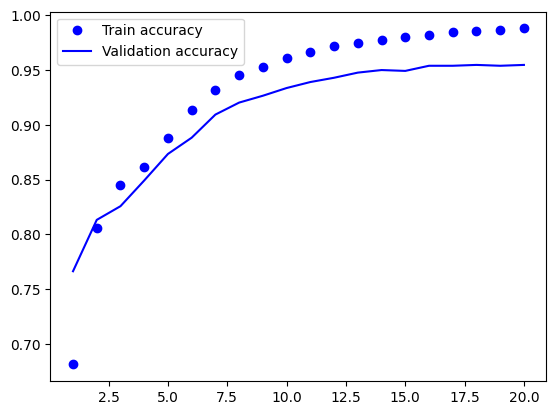

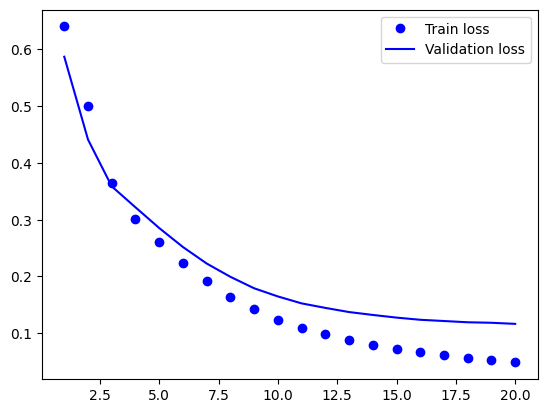

In [14]:
# Model
model = Sequential()
model.add(Embedding(NB_WORDS, 20, input_length=MAX_LEN))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define helper function for training
def train_and_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    history = model.fit(X_train, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_valid, y_valid), verbose=1)
    return history

# Prepare data (assuming df, X_train_seq_trunc, y_train_le, etc. are already defined as per your existing setup)
# Splitting off validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_le,
                                                                      test_size=0.1, random_state=37)

# Train the model
history = train_and_evaluate_model(model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

eval_metric(emb_history, 'accuracy')
eval_metric(emb_history, 'loss')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 53, 20)            200000    
                                                                 
 gru (GRU)                   (None, 128)               57600     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 257729 (1006.75 KB)
Trainable params: 257729 (1006.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
23/23 [==============================] - 10s 331ms/step - loss: 0.6287 - accuracy: 0.7027 - val_loss: 0.4679 - val_accuracy: 0.8102
Epoch 2/20
23/23 [==============================] - 8s 361ms/step - loss: 0.3086 - accuracy: 0.8644 - val_loss: 0.2784 - val_accuracy

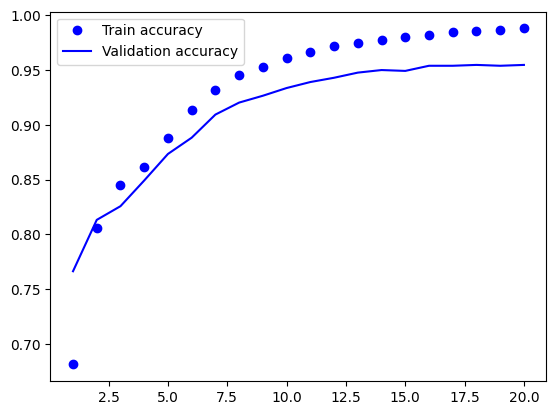

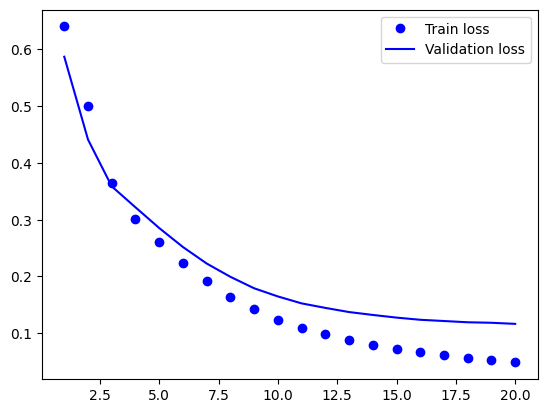

In [15]:
# Model
model = Sequential()
model.add(Embedding(NB_WORDS, 20, input_length=MAX_LEN))
model.add(GRU(128))  # Replacing LSTM with GRU
model.add(Dense(1, activation='sigmoid'))

# Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define helper function for training
def train_and_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    history = model.fit(X_train, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_valid, y_valid), verbose=1)
    return history

# Prepare data (assuming df, X_train_seq_trunc, y_train_le, etc. are already defined as per your existing setup)
# Splitting off validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_le,
                                                                      test_size=0.1, random_state=37)

# Train the model
history = train_and_evaluate_model(model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

eval_metric(emb_history, 'accuracy')
eval_metric(emb_history, 'loss')
